## Home assigment von Alfons Dauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from functools import reduce
from sklearn.preprocessing import StandardScaler

First we load the data into a pandas dataframe.

In [2]:
validation = pd.read_csv("validation.csv")
train = pd.read_csv("training.csv")

In [3]:
train.shape

(3700, 1)

Now let us take a first look into the data frame:

In [4]:
train.head(15)

,,,"v1;""v2"";""v3"";""v4"";""v5"";""v6"";""v7"";""v8"";""v9"";""v10"";""v11"";""v12"";""v13"";""v14"";""v15"";""v17"";""v18"";""v19"";""classLabel"""
a;17,92;5,"4e-05;""u"";""g"";""c"";""v"";1","75;""f"";""t"";1;""t"";""g"";80;5;8e+05;""t"";0;""no."""
b;16,92;3,"35e-05;""y"";""p"";""k"";""v"";0","29;""f"";""f"";0;""f"";""s"";200;0;2e+06;NA;0;""no."""
b;31,25;0,"0001125;""u"";""g"";""ff"";""ff"";0;""f"";""t"";1;""f"";""g"";96;19;960000;""t"";0;""no.""",NaN
a;48,17;0,"0001335;""u"";""g"";""i"";""o"";0","335;""f"";""f"";0;""f"";""g"";0;120;0;NA;0;""no."""
b;32,33;0,"00035;""u"";""g"";""k"";""v"";0","5;""f"";""f"";0;""t"";""g"";232;0;2320000;""f"";0;""no."""
a;34,83;0,"000125;""y"";""p"";""i"";""h"";0","5;""f"";""f"";0;""t"";""g"";160;0;1600000;""f"";0;""no."""
a;26,"17;2e-04;""u"";""g"";""j"";""j"";0;""f"";""f"";0;""t"";""g"";276;1;2760000;NA;0;""no.""",NaN,NaN
b;21,17;8,"75e-05;""y"";""p"";""c"";""h"";0","25;""f"";""f"";0;""f"";""g"";280;204;2800000;NA;0;""no."""
b;28,92;3,"75e-05;""u"";""g"";""c"";""v"";0","29;""f"";""f"";0;""f"";""g"";220;140;2200000;NA;0;""no."""
b;18,17;0,"001025;""u"";""g"";""c"";""h"";1","085;""f"";""f"";0;""f"";""g"";320;13;3200000;NA;0;""no."""


## 1a)
This doesen't look nice. First things that got my attention:

1. The columns have to be seperated from one another.
2. There are multiple index and some information is written into the index. Also I do not know if there is in fact a real index or not. I will just interpret everything as a variable. If there is indeed an index somewhere and the data set is ordered it could lead to a problem. I will have to keep that in mind.
3. The variable names are non-descriptive. This leads to: 
    - feature engineering with a priori knowledge is impossible
    - we don't know if some variables are rounded and continuous or categorical/ordinal
    - we don't know if false positives and false negatives have the same cost
    - no way of interpreting the results

4.

In [5]:
sum(train.isnull().any(axis=1))

1691

Thats a lot of rows with missing values considering we only have 3700 rows to begin with. Trying to recover the missing values could be worth the hassle but for this we need to find out what variables are acutally missing. So i just drop them for now.

In [6]:
train = train.dropna()

Now let us do the same for the validation set

In [7]:
sum(validation.isnull().any(axis=1))

75

In [8]:
validation = validation.dropna()


## 1b) 
So far i don't find it necessary to remove features since we don't have that many, even if some are probably useless like the one with a bunch of zeros in front. Also one variable has a lot of NAs but since it is categorical i will just remove it after one-hot encoding the available information of that variable.

In [9]:
"""
function to tidy up the data frame
"""
def tidy_data(df):
    
    flat_data = index_to_data(df)
    column_names = get_column_names(df)
    
    data = pd.DataFrame(flat_data, columns = column_names)
    data = data.replace('"', '', regex=True)
    
    return data

"""
function to combine the data from all the indeces with the row data
"""
def index_to_data(df):

    # put the data from the index into the columns
    temp = []
    for i in range(df.shape[0]):
        temp.append(list(df.index[i]) + list(df.iloc[i]))
        
    # flatten data of every row into one list
    flat_data = []
    for i in range(df.shape[0]):
        flat_data.append([x.split(';') for x in temp[i] if str(x) != 'nan'])
        flat_data[i] = sum(flat_data[i], [])
        
    # check if all rows have the same length
    len_first = len(flat_data[0]) if flat_data else None
    assert all(len(i) == len_first for i in flat_data), "Not all datapoints have the same number of dimensions after removing na and flattening"
    
    return flat_data

"""
function to get the column names of our df
"""
def get_column_names(df):
    column_names = list(df)[0].replace('"', '').split(";")
    column_names.insert(15, 'v16')

    # I am not sure if the first two var are an index, i first add them as variables and maybe remove them later.
    column_names.insert(0, 'var_ind_2')
    column_names.insert(0, 'var_ind_1')
    
    return column_names

In [10]:
tidy_train = tidy_data(train)
tidy_val = tidy_data(validation)

In [11]:
tidy_train.head()

,var_ind_1,var_ind_2,v1,v2,v3,v4,v5,v6,v7,v8,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,classLabel
0,a,17,92,5,4e-05,u,g,c,v,1,...,t,1,t,g,80,5,8e+05,t,0,no.
1,b,16,92,3,35e-05,y,p,k,v,0,...,f,0,f,s,200,0,2e+06,NA,0,no.
2,a,48,17,0,0001335,u,g,i,o,0,...,f,0,f,g,0,120,0,NA,0,no.
3,b,32,33,0,00035,u,g,k,v,0,...,f,0,t,g,232,0,2320000,f,0,no.
4,a,34,83,0,000125,y,p,i,h,0,...,f,0,t,g,160,0,1600000,f,0,no.


Before we can work with our classification models we transform the data to numpy arrays and one-hot encode the categorical variables.

In [12]:
"""
function to transform the df into a matrix we can work with.
"""
def df_to_matrix(df, categorical_variables): # categorical_variables is a list of column names that are categorical/strings

    dummy_var = dummy_encode(df, categorical_variables)
    df = df.drop(categorical_variables, axis = 1)
    
    DV, IV = get_IV_DV(df, dummy_var)
    
    return DV, IV

"""
function to dummy encode the categorical variables
"""
def dummy_encode(df, categorical_variables):
    
    dummy_var = pd.get_dummies(df[categorical_variables], drop_first = True)
    dummy_var = dummy_var.as_matrix()
    
    return dummy_var

"""
function to split the data into the independent variables and dependent variable. The DV has to be the last dummy_var
"""
def get_IV_DV(numeric_var, dummy_var):
    
    DV = dummy_var[:, dummy_var.shape[1]-1]
    IV_dummies = dummy_var[:, :-1]
    
    # scale the numeric variables
    numeric_var = numeric_var.as_matrix()
    scaler = StandardScaler()
    IV_numeric = scaler.fit_transform(numeric_var.astype(float))
    
    IV = np.c_[IV_numeric, IV_dummies]
    
    return DV, IV

In [13]:
#drop NAs except if NA is in v18
tidy_train = tidy_train[~tidy_train.drop('v18', axis = 1).eq('NA').any(1)]
tidy_val = tidy_val[~tidy_val.drop('v18', axis = 1).eq('NA').any(1)]

concatenation_point = tidy_train.shape[0]
tidy_data = pd.concat([tidy_train, tidy_val])

categorical_variables = ['var_ind_1', 'v4', 'v5', 'v6', 'v7', 'v10', 'v11', 'v13', 'v14', 'v18', 'classLabel']

DV, IV = df_to_matrix(tidy_data, categorical_variables)

C:\Users\User\Anaconda3\envs\praktikum\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\User\Anaconda3\envs\praktikum\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
DV_train = DV[:concatenation_point]
IV_train = IV[:concatenation_point,:]

DV_val = DV[concatenation_point:]
IV_val = IV[concatenation_point:,:]

In [15]:
np.unique(DV, return_counts = True)

(array([0, 1], dtype=uint8), array([ 215, 1862], dtype=int64))

The classes are very unbalanced. There are a couple ways we can deal with this. I try simple oversampling first. I have to be kind of careful because we only have 147 data points in one category.

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
IV_resampled, DV_resampled = ros.fit_resample(IV_train, DV_train)

In [17]:
# I use a logistic regression as a first model to try

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l2', random_state=0, solver = 'lbfgs').fit(IV_resampled, DV_resampled)

In [18]:
lr.score(IV_resampled, DV_resampled)

1.0

In [19]:
lr.score(IV_val, DV_val)

0.48360655737704916

In [20]:
lr.coef_[0]

array([ 1.01008946e-01, -4.63490473e-02,  2.60282746e-02,  7.25042623e-02,
        1.89729840e-01,  2.36480978e-02,  2.68788655e-01, -4.24408077e-02,
        1.76965759e-01, -4.24408077e-02,  4.14705072e+00, -8.22541817e-02,
       -6.31610237e-02, -6.31610237e-02, -4.17433449e-03, -9.88853511e-03,
        8.96878600e-02, -2.02161131e-02, -8.30356239e-03, -4.16286371e-02,
       -6.64595905e-02, -5.19156332e-03, -7.76353502e-02, -2.31835707e-02,
        3.83133120e-02,  5.50318193e-03,  1.23797259e-01, -4.16286371e-02,
        3.19769916e-02,  2.48699347e-02,  1.54752846e-03, -1.10846650e-02,
        1.72016519e-03,  0.00000000e+00,  5.69505511e-01,  1.58727656e-01,
       -1.13004179e-02, -7.23177785e-03,  1.88970962e-03, -1.29139299e-01,
        4.21887644e-02])

In [21]:
import matplotlib.pyplot
plt.pyplot.bar(range(len(lr.coef_[0])), lr.coef_[0])

<BarContainer object of 41 artists>

We hopelessly overfit on the training data. Plotting the coefficients we see that the model is basically only looking at the variable 'v10'. Unfortunately, the connection between v10 and classLabel only exists in the training data. So I drop the variable and retrain the model.

In [22]:
IV_resampled.shape

(3616, 41)

In [23]:
IV_resampled = np.delete(IV_resampled, 10, 1)
IV_val = np.delete(IV_val, 10, 1)

In [24]:
lr = LogisticRegression(penalty = 'l2', random_state=0, solver = 'lbfgs').fit(IV_resampled, DV_resampled)
lr.score(IV_resampled, DV_resampled)

0.8896570796460177

In [25]:
lr.score(IV_val, DV_val)

0.8934426229508197

Aha! it seems that removing that feature was all we needed to do to get a working model. We get an accuracy of 89% on our validation set. Comparing it to the accuracy in our training set suggests that we don't overfit.

Of course accuracy is not the best metric in our unbalanced data set. For a better assessement let us look at the confusion matrix:

In [26]:
from sklearn.metrics import confusion_matrix

pred_val = lr.predict(IV_val)
confusion_matrix(DV_val, pred_val)

array([[60,  8],
       [ 5, 49]], dtype=int64)

The ratio seems decent. We get a precision of 0.88 and a recall of 0.92.

With more time i could try other things to get beter predictions.
Now let us see the new coefficients.

<BarContainer object of 40 artists>

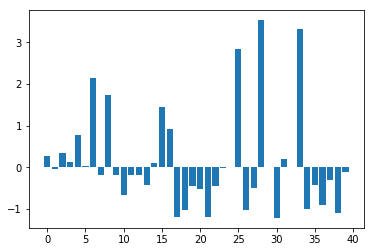

In [27]:
plt.pyplot.bar(range(len(lr.coef_[0])), lr.coef_[0])

## Verbesserungsmöglichkeiten
(nach Priorität geordnet)
### Predictive Modeling:

- Modell anpassen, falls False Positives und False Negatives verschieden viele Kosten verursachen.
- mehr Modelle/mehr Hyperparametertuning wie z. B. tree based models, SVMs. In diesem Fall würden wir mehrere Modelle testen und brauchen dann neben dem Validationsset noch ein Testset.
- Besser mit den NA Werten umgehen, anstatt die entsprechenden Zeilen einfach aus dem Modell zu schmeißen. Z.B. anhand der Sequenz herausfinden, welche Variablen in jeder Zeile fehlen und dann evtl. entsprechende Variablen rausschmeißen oder versuchen NaNs zu predicten
- feature Engineering: dafür wäre vor allem ein Verständnis für die einzelnen Variablen nützlich. Also irgendwie in Erfahrung bringen, was die Variablen eigentlich repräsentieren.
- Weitere Metriken neben Genauigkeit zur Evaluation des Algorithmus heranziehen. Zum Beispiel ROC-AUC. Das ist nicht so mega wichtig mMn, weil die Confusion Matrix uns doch recht solide Ergebnisse gezeigt hat.
- Anders mit den Unbalancierten Klassen umgehen. Z.B. SMOTE, ROC oder kostensensitive Lossfunktionen. Letzteres ist auch nützlich falls False Positives und False Negatives mit verschieden viel Kosten verbunden sind

### Data Pipeline:
- Pipeline verallgemeinern: Falls man erwarten kann, dass man immer mal wieder Datensets mit ähnlicher Struktur erhält vereinfacht automatisiertes Data Cleaning die Arbeit erheblich. Zurzeit funktioniert das nur für dieses spezielle Datenset.
- Unit Tests, Assert Lines

